In [1]:
%matplotlib inline
import torch as tc
import tensorflow as tf
import mxnet as mx
from mxnet import np as mxnp
from mxnet import npx as npx
npx.set_np()
# import numpy as np

from d2l import mxnet as mxd2l  # Use MXNet as the backend
from d2l import torch as tcd2l  # Use PyTorch as the backend
from d2l import tensorflow as tfd2l  # Use TensorFlow as the backend

tc.__version__,tf.__version__,mx.__version__

('1.6.0', '2.3.1', '1.7.0')

In [2]:
import math
from torch import nn
from torch.nn import functional as F

In [3]:
batch_size,num_steps=32,35

In [4]:
train_iter,vocab=tcd2l.load_data_time_machine(batch_size,num_steps)

In [5]:
F.one_hot(tc.tensor([0,2]),len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [7]:
F.one_hot(tc.tensor([0,2,1]),3)

tensor([[1, 0, 0],
        [0, 0, 1],
        [0, 1, 0]])

In [12]:
X=tcd2l.reshape(tc.arange(10),(2,5))
X

tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]])

In [13]:
X=X.T
X

tensor([[0, 5],
        [1, 6],
        [2, 7],
        [3, 8],
        [4, 9]])

In [29]:
X=F.one_hot(X,len(vocab))
X.shape

torch.Size([5, 2, 28, 28])

In [127]:
import torch as tc
import math
from torch import nn
from torch.nn import functional as F
from d2l import torch as tcd2l  # Use PyTorch as the backend

train_iter,vocab=tcd2l.load_data_time_machine(32,35)
class RnnModelScrach:
    def __init__(self, vocab_size, num_hiddens, device):
        self.vocab_size = vocab_size
        self.num_hiddens = num_hiddens
        self.device = device
        self.params = self.get_params(vocab_size, num_hiddens)

    def get_params(self, vocab_size, num_hiddens):
        def normal(size):
            return tc.randn(size, dtype=tc.float32, device=self.device) * 0.01

        W_xh = normal((vocab_size, num_hiddens))
        W_hh = normal((num_hiddens, num_hiddens))
        b_h = tc.zeros(num_hiddens, device=self.device)
        W_ho = normal((num_hiddens, vocab_size))
        b_o = tc.zeros(vocab_size, device=self.device)

        params = [W_xh, W_hh, b_h, W_ho, b_o]
        for param in params:
            param.requires_grad_(True)
        return params

    def begin_state(self, batch_size):
        return tc.zeros((batch_size, self.num_hiddens), device=self.device)

    def __call__(self, X, state):
        X = X.T
        X = F.one_hot(X, self.vocab_size).type(tc.float32)
        X=X.to(self.device)
        batch_size = X.shape[1]
        if state is None:
            state = self.begin_state(batch_size)

        outputs, H = self.forward(X, state, self.params)
        return outputs, H

    def forward(self, inputs, state, params):
        W_xh, W_hh, b_h, W_ho, b_o = params
        
        outputs = []
        for x in inputs:
            state = tc.tanh(tc.mm(x, W_xh) + tc.mm(state, W_hh) + b_h)
            Y = tc.mm(state, W_ho) + b_o
            outputs.append(Y)
        outputs = tc.cat(outputs, dim=0)
        return outputs, state
    def predict(self,prefix,num_preds,vocab=vocab):
        state=self.begin_state(batch_size=1)
        outputs=[vocab[prefix[0]]]
        get_input=lambda:tcd2l.reshape(tc.tensor([outputs[-1]],device=self.device),(1,1))
        for y in prefix[1:]:
            # _,state=self.__call__(get_input(),state)
            _, state = self(get_input(), state)
            outputs.append(vocab[y])
        for _ in range(num_preds):
            # y,state=self.__call__(get_input(),state)
            y, state = self(get_input(), state)
            outputs.append(int(y.argmax(dim=1).reshape(1)))
        return "".join([vocab.idx_to_token[i] for i in outputs])

rnn=RnnModelScrach(28,56,tcd2l.try_gpu())
X=tcd2l.reshape(tc.arange(10),(2,5))
Y,H=rnn(X,None)
print(Y.shape,H.shape)
r=rnn.predict("abcd ",6)
print(r)


torch.Size([10, 28]) torch.Size([2, 56])
abcd yupadk


In [128]:
rnn.predict("abcd ",6)

'abcd yupadk'

In [129]:
def grad_clipping(model, theta):  #@save
#     pass
    """Clip the gradient."""
    if isinstance(model, nn.Module):
        params = [p for p in model.parameters() if p.requires_grad]
    else:
        params = model.params
    norm = tc.sqrt(sum(tc.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [133]:
def train_epoch(model,train_iter,loss,updater,use_random_iter):
    state=None
    timer=tcd2l.Timer()
    metric=tcd2l.Accumulator(2)
    for X,Y in train_iter:
        if state is None or use_random_iter:
            state=model.begin_state(batch_size=X.shape[0])
        else:
            state.detach_()
        y=Y.T.reshape(-1)  #Y(batch_size*num_steps),先转置(因X也转置了，要保持一致)，再打平，一共batch_size*num_steps个元素
        X,y=X.to(model.device),y.to(model.device)
        y_hat, state = model(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, tc.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(model, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(model, 1)
            # Since the `mean` function has been invoked
            updater(batch_size=1)
#             print(model.params[0].sum())
        metric.add(l * tcd2l.size(y), tcd2l.size(y))
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [134]:
def train_ch8(model, train_iter, vocab, lr, num_epochs, use_random_iter=False):
    """Train a model (defined in Chapter 8)."""
    loss = nn.CrossEntropyLoss()
    animator = tcd2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs],ylim=[1, 20]) #,ylim=[1, 20]
    # Initialize
    if isinstance(model, nn.Module):
        updater = torch.optim.SGD(model.parameters(), lr)
    else:
        updater = lambda batch_size: tcd2l.sgd(model.params, lr, batch_size)
    predict = lambda prefix: model.predict(prefix, 50)
    # Train and predict
    for epoch in range(num_epochs):
        ppl, speed = train_epoch(
            model, train_iter, loss, updater,use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {str(model.device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

perplexity 1.0, 79292.4 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby
traveller with a slight accession ofcheerfulness really thi


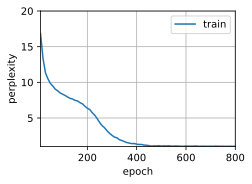

In [138]:
batch_size, num_steps = 32, 35
train_iter, vocab = tcd2l.load_data_time_machine(batch_size, num_steps)

rnn=RnnModelScrach(28,512,tcd2l.try_gpu())
num_epochs, lr = 800, 0.5
train_ch8(rnn, train_iter, vocab, lr, num_epochs)

perplexity 2.3, 77544.1 tokens/sec on cuda:0
time traveller have jere aflethere is to be acke al over tatien 
traveller haven the lilies of space here is a pling the pro


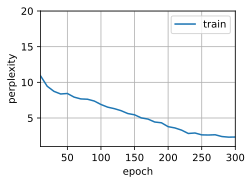

In [140]:
batch_size, num_steps = 32, 35
train_iter, vocab = tcd2l.load_data_time_machine(batch_size, num_steps)

rnn=RnnModelScrach(28,512,tcd2l.try_gpu())
num_epochs, lr = 300, 2
train_ch8(rnn, train_iter, vocab, lr, num_epochs, use_random_iter=True)